In [11]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import numpy as np

In [2]:
#Load in the data
df = pd.read_csv('readmissions_data_clean.csv')
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted,age_midpoint
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,0,1,0,75.0
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,0,1,0,75.0
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,1,1,1,55.0
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,1,1,1,75.0
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,0,1,0,65.0


In [3]:
# Define feature columns and target variable
features = df.drop(columns=['readmitted'])
target = df['readmitted']

# Convert categorical variables to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/lillyamirjavadi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/Users/lillyamirjavadi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/Users/lillyamirjavadi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):


In [5]:
#Feature selection using recursive feature elimination (RFE)

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Initialize RFE with the logistic regression model and the number of features to select
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
rfe.fit(X_train_scaled, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['n_outpatient', 'n_inpatient', 'n_emergency', 'diabetes_med',
       'age_midpoint', 'age_[90-100)', 'medical_specialty_Other',
       'diag_1_Diabetes', 'diag_1_Missing', 'diag_3_Missing'],
      dtype='object')


In [6]:
# Train the model using only the selected features
X_train_selected = X_train_scaled[:, rfe.support_]
X_test_selected = X_test_scaled[:, rfe.support_]

model.fit(X_train_selected, y_train)

LogisticRegression(max_iter=1000)

In [9]:
#Model evaluation
# Make predictions
y_pred = model.predict(X_test_selected)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.79      0.68      3974
           1       0.63      0.41      0.50      3526

    accuracy                           0.61      7500
   macro avg       0.62      0.60      0.59      7500
weighted avg       0.61      0.61      0.59      7500

Confusion Matrix:
 [[3125  849]
 [2081 1445]]
Accuracy: 0.61
Precision: 0.63
Recall: 0.41
F1 Score: 0.50
ROC-AUC Score: 0.64


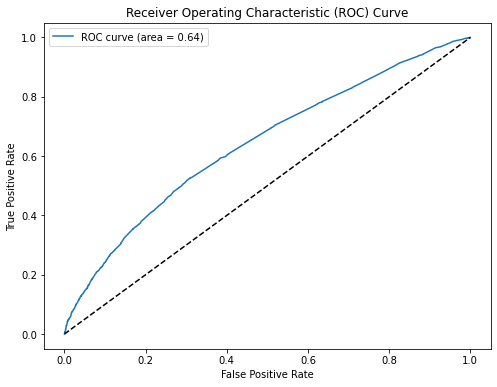

In [10]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

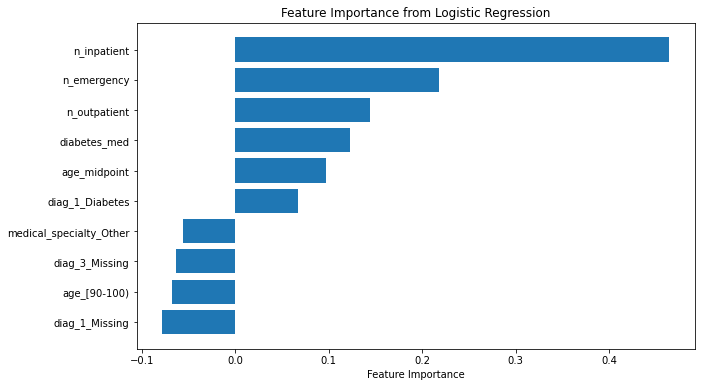

In [12]:
# Get feature importance
importance = model.coef_[0]

# Plot feature importance
indices = np.argsort(importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Logistic Regression')
plt.show()